# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.


                                                                                               - Trisit Kumar Chatterjee
                                                                                               - Subhasis Jethy

In [1]:
# import important libraries
import numpy as np
import pandas as pd
import os
#from scipy.misc import imread, imresize

from skimage.io import imread
from skimage.transform import resize as imresize
import cv2
import matplotlib.pyplot as plt
import datetime

In [2]:
# Import all the required Keras modules
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import LeakyReLU
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30) # Corrected
tf.__version__

'2.1.3'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 32#experiment with the batch size

In [5]:
train_path = './Project_data/train' # To be used as source_path in generator function
val_path = './Project_data/val'

## EDA - Analysis of the Images to see the size and augmentation requirements

- All the images present in the folder are of size either 120x160x3 or 360x360x3. 
- So they have to be brought to same size i.e. bring them to size 120x120x3 or 100x100x3 as necessary

In [6]:
# Create a seperate data frame of train data for EDA
train_df = pd.read_csv('./Project_data/train.csv',header = None)
train_df = train_df[0].str.split(pat = ';',expand = True)
train_df.rename(columns = {0: 'Name', 1: 'Gesture', 2: 'Class'},inplace = True)
train_df.sample(n=5, random_state=30)


,Name,Gesture,Class
152,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
314,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
12,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
413,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
74,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


In [7]:
# Check for class imbalance
train_df['Class'].value_counts()

3    137
1    137
0    136
2    130
4    123
Name: Class, dtype: int64

- One can see good fair distribution of videos for every class. So all five classes are well balanced

In [9]:
# Let us see images are of which shape. It will help us in reshaping all of them to the same size
shape_120_160 = 0
shape_360_360 = 0
shape_rest = 0

for folder in train_df['Name']:
    temp = os.listdir('./Project_data/train'+'/'+ folder)
    if(imread('./Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (120,160,3)):
        shape_120_160 += 1
    elif(imread('./Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (360,360,3)):
        shape_360_360 += 1
    else:
        shape_rest += 1
         
print('Number of images with shape 120x160x3:', shape_120_160)
print('Number of images with shape 360x360x3:', shape_360_360)
print('Number of images with other shapes   :', shape_rest)

Number of images with shape 120x160x3: 479
Number of images with shape 360x360x3: 184
Number of images with other shapes   : 0


- As one can see images are either of 120x160x3 or 360x360x3 shape
- They will be reshaped to 120x120x3 or 100x100x3 as necessary later in the code

In [10]:
# This is a custom function to show the images and their augmentation
def imageview(class_img, source_path):
    
    # Get all 30 images in the folder
    images = os.listdir(source_path+'/'+ class_img)
    # Select one image (I have chosen 25th image) among the 30 images
    image = imread(source_path+'/'+ class_img +'/'+images[24])
    print('original:',image.shape)
    
    # Resize the image
    resized_img = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
    print('resized:',resized_img.shape)
    
    # Apply Gaussian Blur on the image
    blur_image = cv2.GaussianBlur(resized_img, (3,3), 3)
    print('blurred:',blur_image.shape)
    
    # Image Edge Detection
    edge_image = cv2.Canny(blur_image, 75, 150)
    # Get it into shape of 120x120x3 to maintain same shape through out (Canny removes the channels)
    edge_image1 = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2BGR)
    print('edge:',edge_image1.shape)
    
    # Normalize the image
    norm_img = resized_img/255
    print('normalized:',norm_img.shape)
    
    fig = plt.figure(figsize = (20, 30))
    
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image)
    
    plt.subplot(152)
    plt.title('Resized')
    plt.imshow(resized_img) 
     
    plt.subplot(153)
    plt.title('Gaussian Blur')
    plt.imshow(blur_image)
    
    plt.subplot(154)
    plt.title('Edges')
    plt.imshow(edge_image1, cmap = 'gray')
    
    plt.subplot(155)
    plt.title('Normalized')
    plt.imshow(norm_img)

    plt.show()

In [11]:
# Consider two images (one with 120x160x3 and another with 360x360x3) each from every class for analysis
class_0_120 = train_df[train_df['Class']=='0'].reset_index()['Name'][2]
class_0_360 = train_df[train_df['Class']=='0'].reset_index()['Name'][133]
class_1_120 = train_df[train_df['Class']=='1'].reset_index()['Name'][0]
class_1_360 = train_df[train_df['Class']=='1'].reset_index()['Name'][131]
class_2_120 = train_df[train_df['Class']=='2'].reset_index()['Name'][1]
class_2_360 = train_df[train_df['Class']=='2'].reset_index()['Name'][121]
class_3_120 = train_df[train_df['Class']=='3'].reset_index()['Name'][1]
class_3_360 = train_df[train_df['Class']=='3'].reset_index()['Name'][130]
class_4_120 = train_df[train_df['Class']=='4'].reset_index()['Name'][5]
class_4_360 = train_df[train_df['Class']=='4'].reset_index()['Name'][111]

Image for Swipe Left:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


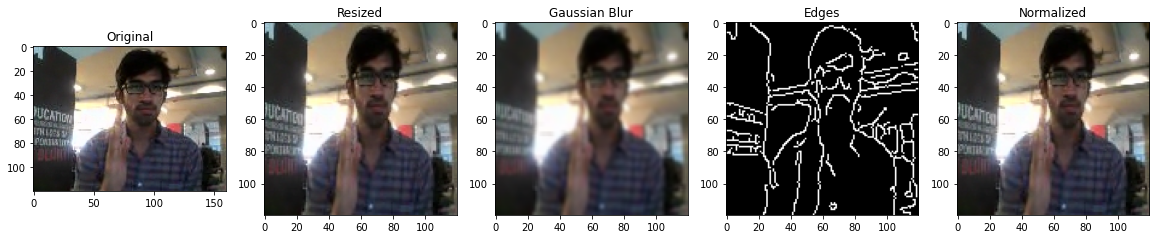

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


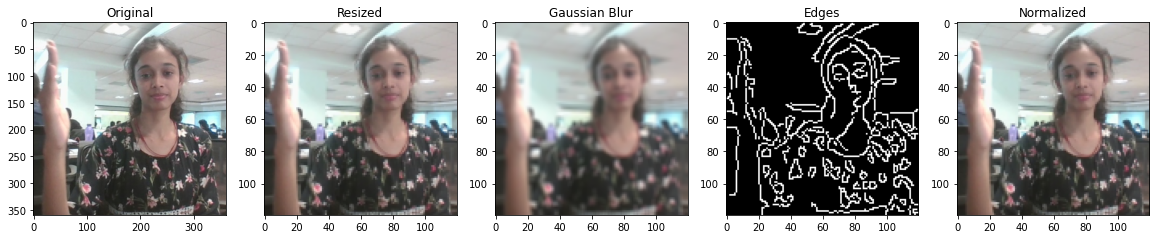

Image for Swipe Right:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


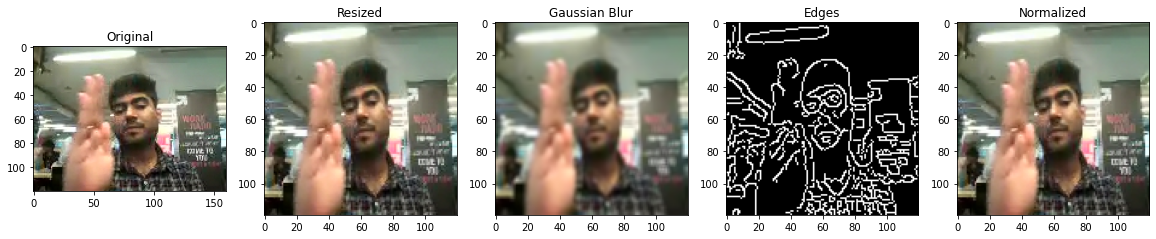

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


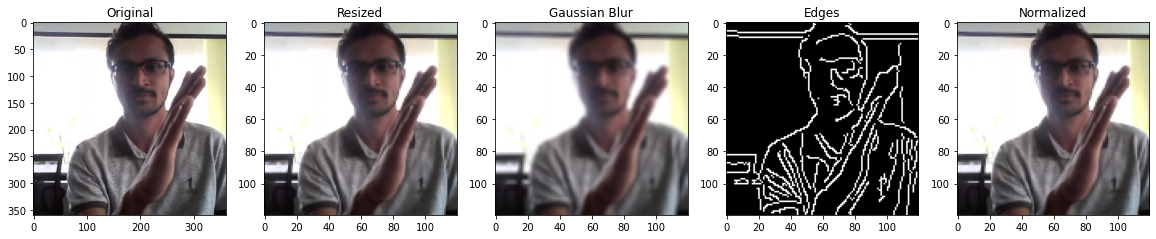

Image for Stop:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


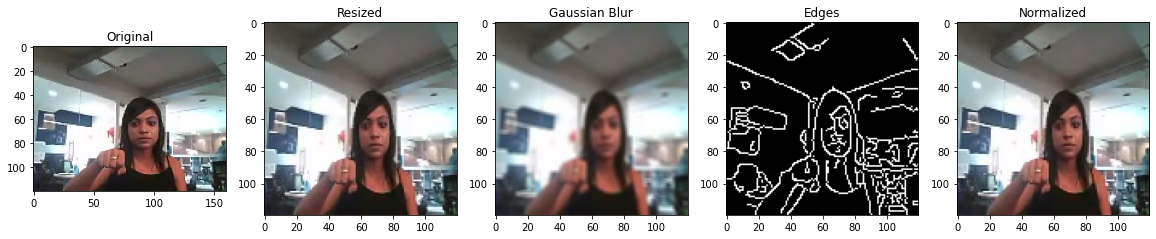

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


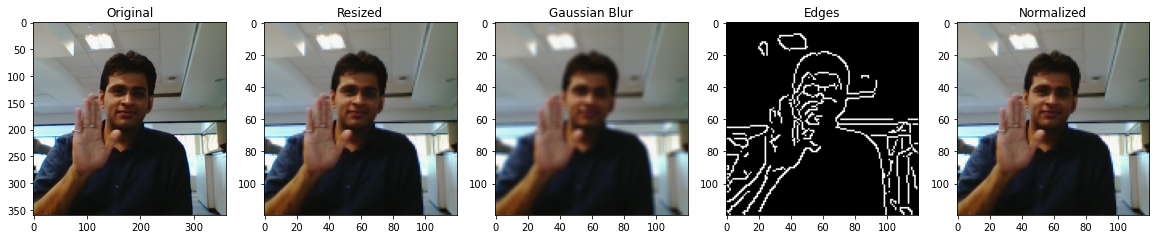

Image for Volume Down:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


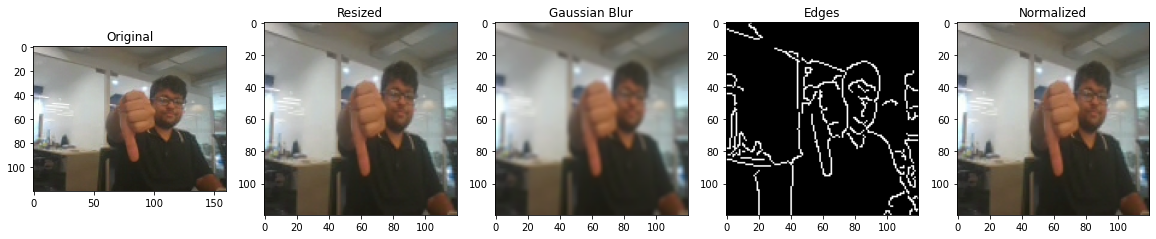

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


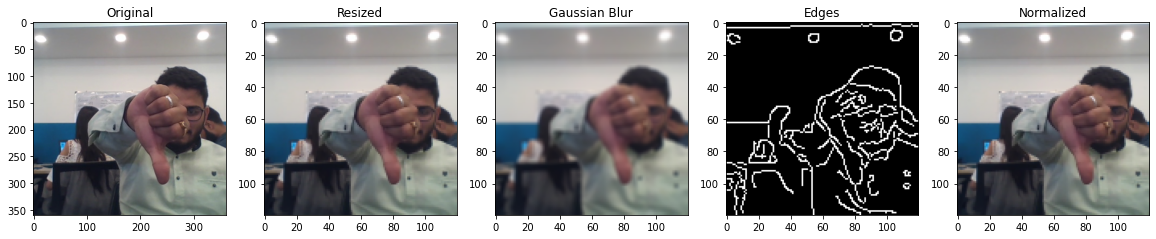

Image for Volume Up:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


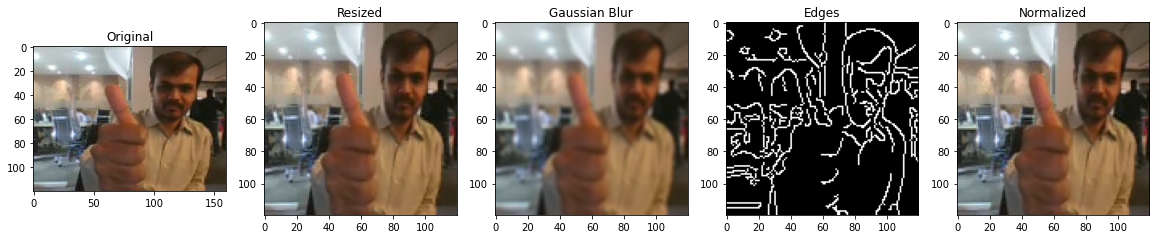

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


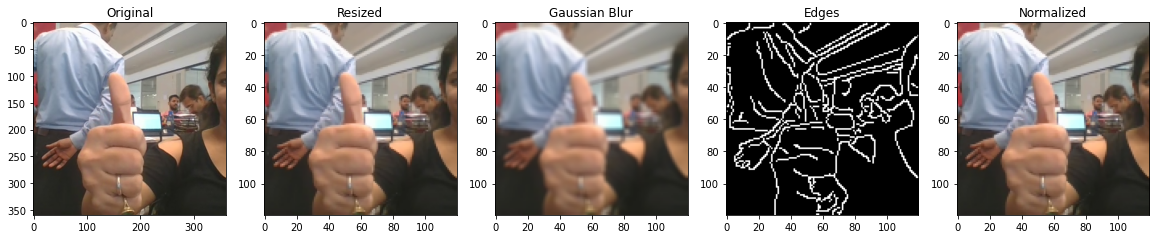

In [12]:
# View the images with their augmented outputs
print('\033[1m' + 'Image for Swipe Left:' + '\033[0m')
imageview(class_0_120, './Project_data/train')
imageview(class_0_360, './Project_data/train')
print('\033[1m' + 'Image for Swipe Right:' + '\033[0m')
imageview(class_1_120, './Project_data/train')
imageview(class_1_360, './Project_data/train')
print('\033[1m' + 'Image for Stop:' + '\033[0m')
imageview(class_2_120, './Project_data/train')
imageview(class_2_360, './Project_data/train')
print('\033[1m' + 'Image for Volume Down:' + '\033[0m')
imageview(class_3_120, './Project_data/train')
imageview(class_3_360, './Project_data/train')
print('\033[1m' + 'Image for Volume Up:' + '\033[0m')
imageview(class_4_120, './Project_data/train')
imageview(class_4_360, './Project_data/train')

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
# The generator function
def generator(source_path, folder_list, batch_size, num_frames, frame_height, frame_width, augment, normalize):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Based on the number of frames, some frames can be skipped in between. Use linspace function to do that
    img_idx = np.round(np.linspace(0, 29, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video
    print("Image Indexes: ", img_idx)
    while True:
        t           = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size) # calculate the number of batches
        for batch in range(num_batches):      # we iterate over the number of batches
            
            batch_data      = np.zeros((batch_size, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels    = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))           
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    if(normalize == True):
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255.0 #normalise and feed in the image       
                    else:
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image                          
                    
                    # Add augmentation (Gaussian Noise Images)
                    if (augment == True):                
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)
                        if(normalize == True):
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image
                        else:
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2]) #normalise and feed in the image                          
                  
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if(augment == True):
                # Add blurred images to the data
                batch_data    = np.concatenate([batch_data, batch_data_blur])
                batch_labels  = np.concatenate([batch_labels, batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining_data = len(t) % batch_size
        if(remaining_data != 0):
            
            batch_data = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels    = np.zeros((remaining_data,5))                                    # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))           

            for folder in range(remaining_data): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    if(normalize == True):
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255.0 #normalise and feed in the image       
                    else:
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image     
                    
                    # Add augmentation (Gaussian Noise Images)
                    if(augment == True):
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)

                        if(normalize == True):
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image
                        else:
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2]) #normalise and feed in the image    

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            if(augment == True):
                # Add blurred images to the data
                batch_data = np.concatenate([batch_data, batch_data_blur])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            yield batch_data, batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### Test the Generator Function

In [14]:
# Test the Generator function on training data set

num_frames    = 20 
frame_height  = 120
frame_width   = 120
augment       = False
normalize     = True

train_generator = generator(train_path, train_doc, batch_size, num_frames, frame_height, frame_width, augment, normalize)

for i in range(int(len(train_doc)//batch_size + 1)):
    batch_data_temp, batch_label_temp = next(train_generator)
    print('Shape of each batch: ',batch_data_temp.shape)
    print('Shape of each batch label: ',batch_label_temp.shape)      

Source path =  ./Project_data/train ; batch size = 32
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch labe

In [15]:
# Test the Generator function on validation data set

num_frames    = 20
frame_height  = 120
frame_width   = 120
augment       = False
normalize     = True

val_generator = generator(val_path, val_doc, batch_size, num_frames, frame_height, frame_width, augment, normalize)

if (len(val_doc)%batch_size) == 0:
    for i in range(int(len(val_doc)/batch_size)):
        batch_data_temp, batch_label_temp = next(val_generator)
        print('Shape of each batch: ',batch_data_temp.shape)
        print('Shape of each batch label: ',batch_label_temp.shape)        
else:
    for i in range(int(len(val_doc)//batch_size + 1)):
        batch_data_temp, batch_label_temp = next(val_generator)
        print('Shape of each batch: ',batch_data_temp.shape)
        print('Shape of each batch label: ',batch_label_temp.shape)  

Source path =  ./Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (4, 20, 120, 120, 3)
Shape of each batch label:  (4, 5)


In [16]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Custom functions

Let us write some custom functions first which need to be repeatedly called
1. **generator()** function which is already written above
2. **trainer()** function to fit and train the model and calculate its accuracy and loss
3. **modelplot()** to plot the model accuracy and losses

In [17]:
# Function to fit and train the Model
def trainer(model, model_name, num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize):
    #normalize = normalize
    # Model with the training data
    train_gen = generator(train_path, train_doc, size_batch, num_frames, frame_height, frame_width, augment, normalize)
    # Calculate steps per epoch
    if (len(train_doc)%size_batch) == 0:
        train_steps_per_epoch = int(len(train_doc)/size_batch)
    else:
        train_steps_per_epoch = (len(train_doc)//size_batch) + 1

    # Model with validation data (Augmentation is not applied on the validation data set)
    augment = False
    val_gen = generator(val_path, val_doc, size_batch, num_frames, frame_height, frame_width, augment, normalize)
    # Calculate steps per epoch
    if (len(val_doc)%size_batch) == 0:
        val_steps_per_epoch = int(len(val_doc)/size_batch)
    else:
        val_steps_per_epoch = (len(val_doc)//size_batch) + 1

    # Callback function to save models   
    curr_dt_time = datetime.datetime.now() # Current date and time to store the models with timestamp
    mod_name = model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(mod_name):
        os.mkdir(mod_name)        
    filepath = mod_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)        
        
    # Callback function to reduce learning rate upon reaching a plateau
    LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 4, verbose = 1) # write the REducelronplateau code here
    
    # Early Stop callback function
    earlystop = EarlyStopping(monitor = "val_loss", mode='auto', patience = 10, verbose = 1)
    
    # List of all callback functions
    callbacks_list = [checkpoint, LR, earlystop]

    # Fit the model
    history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch, 
                                      epochs = num_epochs, verbose = 1,
                                      callbacks = callbacks_list, workers = 1, 
                                      initial_epoch = 0, class_weight = None,
                                      validation_data = val_gen, 
                                      validation_steps = val_steps_per_epoch)                                        
  
    return history_obj

In [18]:
# Custom function for plotting accuracies and losses of the model
def modelplot(history):
    
    fig = plt.figure(figsize = (16, 5))
    
    # Plot the loss
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train_loss','val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plot the accuracy
    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.legend(['train_categorical_accuracy','val_categorical_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.show()

In [19]:
# print(just to give an error)

### Sample Model to Test
- Write a sample model to decide the batch size, image size and number of frames

In [20]:
# Test Conv3D Model for test run
def model_Conv3D_Test(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3,3,3)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

### Deciding the batch size, image size and number of frames

Time taken and the memory needed to train the model is greatly affected by the batch size, image size and number of frames. We do as below:
- Experiment with different batch size till we hit the OOM error of GPU
- Let us try three image sizes - 100x100, 120x120 and 160x160
- Choose appropriate number of frames

#### Choosing Batch Size

- We choose the batch size as 32 and number of frames as 24 to avoid OOM error
- However, depending on the model architecture we may change thi if needed

In [23]:
# Model with image size 100x100

num_frames    = 24
frame_height  = 100
frame_width   = 100
batch_size    = 32
num_epochs    = 2
augment       = False # Add Gaussian Blurring taken care in Generator function
normalize     = True  # Diving image channel wise by 255 taken care in Generator function

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam() 
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, batch_size, num_frames, frame_height, frame_width, augment, normalize)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 24, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 24, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 33, 33, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 33, 33, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 33, 33, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 33, 33, 32)    

In [24]:
# Model with image size 120x120
 
num_frames    = 24
frame_height  = 120
frame_width   = 120
size_batch    = 32
num_epochs    = 2
augment       = False
normalize     = True

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam() 
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 24, 120, 120, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 24, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 40, 40, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 8, 40, 40, 32)     4128      
_________________________________________________________________
activation_7 (Activation)    (None, 8, 40, 40, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 40, 40, 32)    

In [ ]:
# # Model with image size 160x160
 
# num_frames    = 8
# frame_height  = 160
# frame_width   = 160
# size_batch    = 24
# num_epochs    = 2
# augment       = False
# normalize     = True  # Diving image channel wise by 255 taken care in Generator function

# model = model_Conv3D_Test(num_frames, frame_height, frame_width)
# optimiser = optimizers.Adam() 
# model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
# print(model.summary())
# # Run the model and check accuracy
# trainer(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

- image with size 160x160 was also tested; however runs into OOM error with higher frame count
- As it can be seen **`120x120` size** seemed better as it takes lesser time and at the same time gives good accuracy. 
- It is a good balance between time and accuracy. 
- It also helps us to choose higher batch size
- We will start with this batch size but we will check further on **`100x100` size** as well in some models

#### Choose number of frames

- We went ahead with one thought: Even one single image is capable enough to determine whether it is a Thumbs Up, Thumbs Down or Stop. For identifying Left and Right Swipes, we need at the most two images. This means we can manage with a smaller number of frames instead of all 30. So, **we chose 16 as the number of frames** (
- This also helps us to tackle overfitting.

As these parameters are decided let us start building the model and decide on other parameters such as filter size, layers etc

### Model Architecture 1 - Conv3D model with filter size (3,3,3)

- We will start with a smaller number of epochs (20) in the beginning till we get all the parameters we need
- We use Conv3D filters of 16,32,64,128 in increasing order and dense layer of 128 and 256

In [25]:
def model_Conv3D_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_13 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 60, 60, 32)    

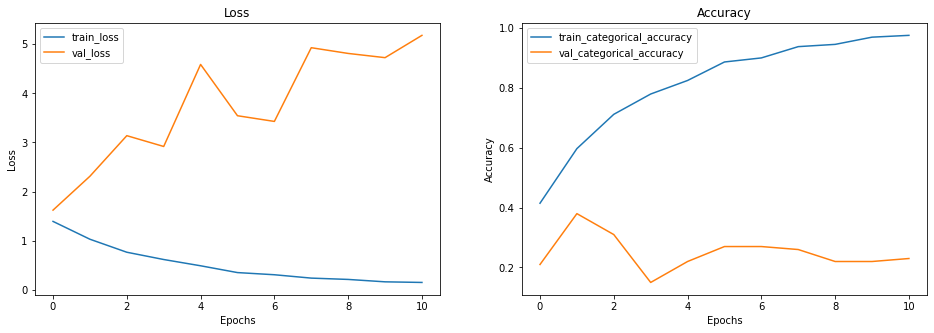

In [26]:
# Model 1 - Conv3D Model with filter size (3,3,3)

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = False
normalize       = True

model = model_Conv3D_1(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

- As one can see, **Model 1 is clearly overfitting**
- Let us see if the kernel size (2,2,2) solves the overfitting problem

### Model Architecture 2 - Conv3D model with filter size (2,2,2)

In [27]:
# Model 2 - Conv3D Model with filter size (2,2,2)
def model_Conv3D_2(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_19 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_20 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 60, 60, 32)    

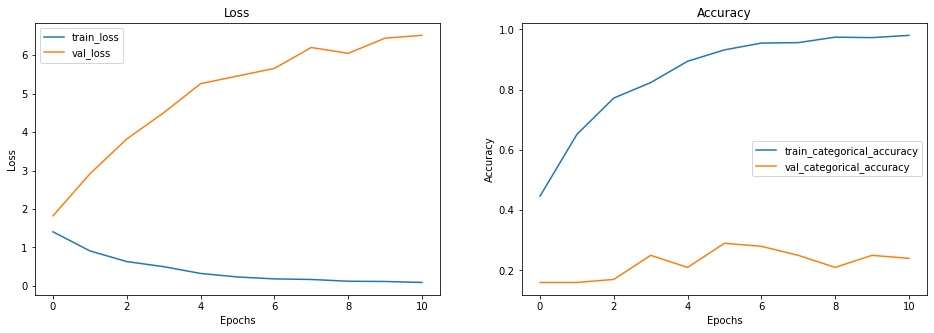

In [28]:
# Model 2 - Conv3D Model with filter size (2,2,2)

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = False
normalization   = True

model = model_Conv3D_2(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

- **Model 2 is also overfitting**
- We next try to improve upon (3,3,3)

### Model Architecture 3 - Conv3D model with filter size (3,3,3) and Augmentation
- We use augmentation and at the same time change the sequence of dense layers  - 64 followed by 128

In [29]:
# Model 3 - Conv3D Model with filter size (3,3,3)
def model_Conv3D_3(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_26 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_27 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 60, 60, 32)    

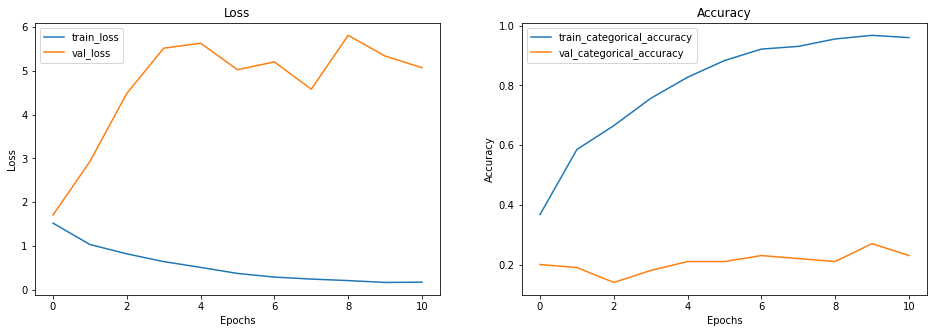

In [30]:
# Model 3 - Conv3D Model with filter size (3,3,3)

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = True

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_34 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 60, 60, 32)    

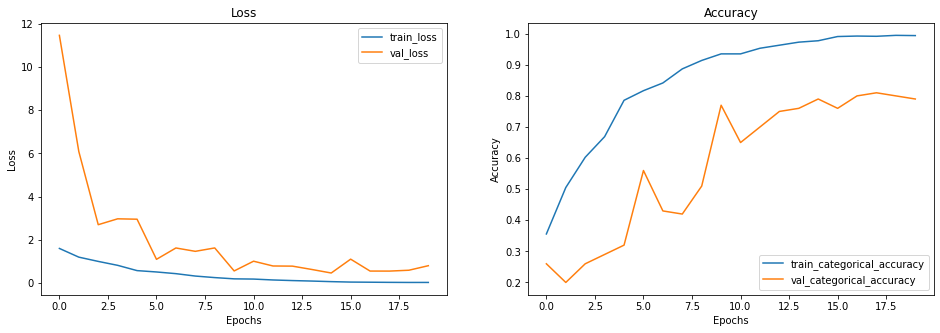

In [31]:
# Model 4 - Conv3D Model with filter size (3,3,3) without Normalization

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

- Till now Model 4 - Conv3D Model with filter size (3,3,3) without Normalization with augmentation has performed the well with `86%` validation accuracy
- Let us see if this can be further improved

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_40 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_41 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 60, 60, 32)    

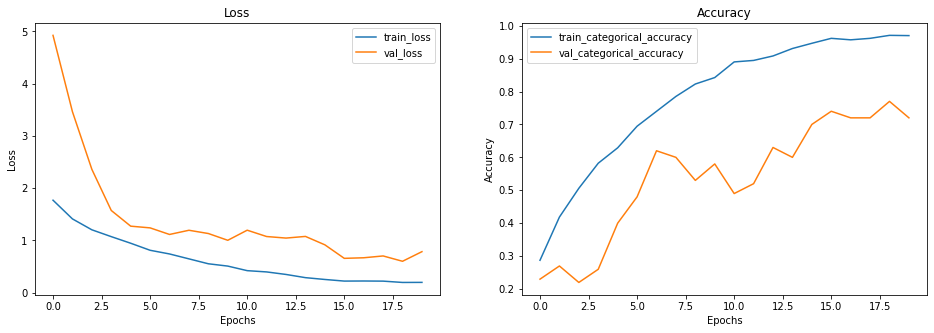

In [32]:
# Model 5 - Conv3D Model with filter size (3,3,3) without Normalization
# This model is same as above but with SGD Optimizer
frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = optimizers.SGD()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_3', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_47 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_48 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 8, 50, 50, 32)    

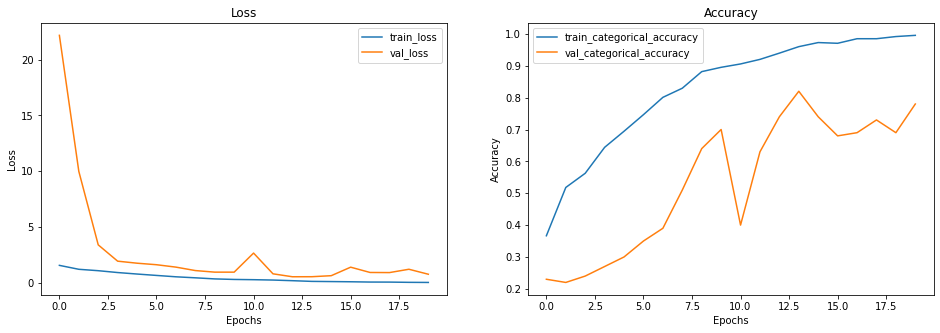

In [33]:
# Model 6 - Conv3D Model with filter size (3,3,3) with augmentation without Normalization and with Framesize 100x100

frame_height    = 100
frame_width     = 100
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_4', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_34 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_54 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_55 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 8, 50, 50, 32)   

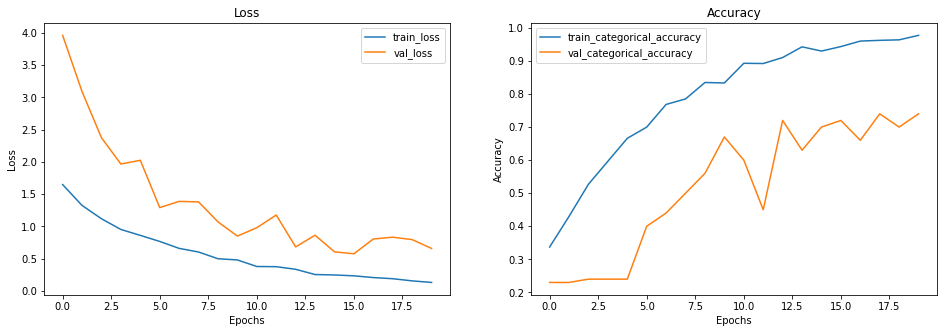

In [34]:
# Model 7 - Conv3D Model with filter size (3,3,3) with augmentation without Normalization and with Framesize 100x100 and SGD Optimizer

frame_height    = 100
frame_width     = 100
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = optimizers.SGD()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_5', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

### Model Architecture 4 - Conv3D model with filter size (3,3,3) and lesser layers
- We use two layers of 64 filters and 1 layer of 128 filter
- After that 512 Dense kernel is added

In [37]:
# Model Architecture 4 - Conv3D Model with filter size (3,3,3)
# Conv3D Filters 8, 16, 32, 64 followed by Dense layers in descending order of 256, 128 and finally 5
def model_Conv3D_4(num_frames, frame_height, frame_width):

    # Define model
    model = Sequential()

    model.add(Conv3D(8, 
                    kernel_size=(3,3,3), 
                    input_shape=(num_frames, frame_height, frame_width,3),
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(16, 
                    kernel_size=(3,3,3), 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32, 
                    kernel_size=(1,3,3), 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64, 
                    kernel_size=(1,3,3), 
                    padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    #softmax layer
    model.add(Dense(5, activation='softmax'))

    return model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 16, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_48 (Batc (None, 16, 100, 100, 8)   32        
_________________________________________________________________
activation_65 (Activation)   (None, 16, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 8, 50, 50, 8)      0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 8, 50, 50, 16)     3472      
_________________________________________________________________
batch_normalization_49 (Batc (None, 8, 50, 50, 16)     64        
_________________________________________________________________
activation_66 (Activation)   (None, 8, 50, 50, 16)   

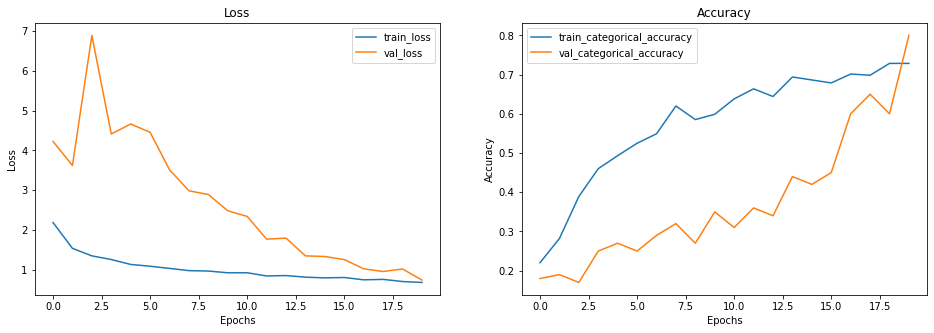

In [38]:
# Model 8 - Conv3D Model with filter size (3,3,3) with augmentation without Normalization and with Framesize 100x100

frame_height    = 100
frame_width     = 100
num_frames      = 16
size_batch      = 64
num_epochs      = 20
augment         = False
normalization   = False

model = model_Conv3D_4(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_4_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

- So far this is the best fit model
- Train accuracy is 85% and validation accuracy is 81%

### Model Architecture 5 -  Conv3D model with filter size (3,3,3) and Leaky ReLU

- Let us improve upon the Conv3D model of filter size (3,3,3) with bit changed architecture and Dense layer of 512

In [39]:
# Conv3D Model with filter size (3,3,3)
def model_Conv3D_5(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(32,(3,3,3), strides=(1,1,1), 
              input_shape = (num_frames, frame_height, frame_width, 3),
              padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling3D(pool_size=(2,2,1),strides=(2,2,1)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv3D(64, (3,3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25)) # Dropout 0.5

    model.add(Flatten())
    model.add(Dropout(0.25)) # Dropout 0.25
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
# Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    return model


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_54 (Batc (None, 15, 100, 100, 32)  128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_46 (MaxPooling (None, 7, 50, 100, 32)    0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 7, 50, 100, 64)    55360     
_________________________________________________________________
batch_normalization_55 (Batc (None, 7, 50, 100, 64)    256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 50, 100, 64)  

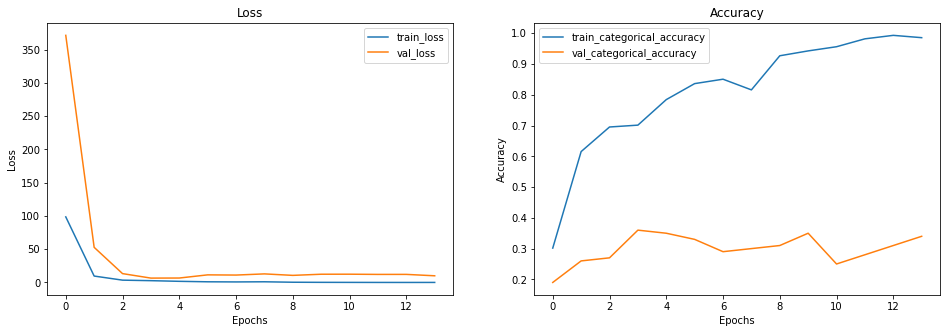

In [41]:
# Model 9 - Conv3D Model with filter size (3,3,3)
frame_height    = 100
frame_width     = 100
num_frames      = 15
size_batch      = 32
num_epochs      = 30
augment         = True
normalize       = True


model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_5_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_55 (Conv3D)           (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_60 (Batc (None, 15, 100, 100, 32)  128       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_50 (MaxPooling (None, 7, 50, 100, 32)    0         
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 7, 50, 100, 64)    55360     
_________________________________________________________________
batch_normalization_61 (Batc (None, 7, 50, 100, 64)    256       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 7, 50, 100, 64)  

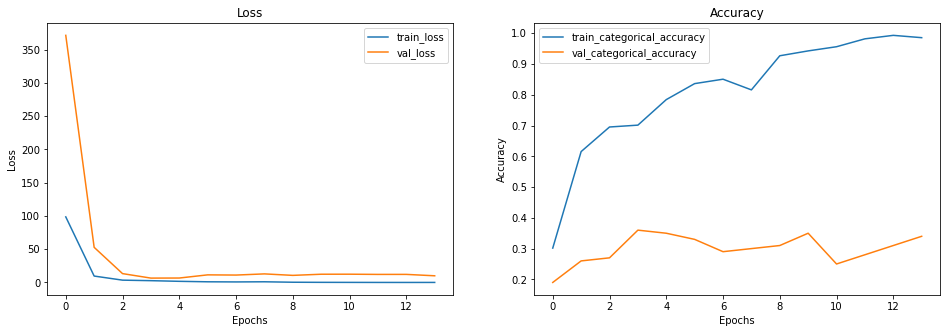

In [43]:
# Model 10 - Conv3D Model with filter size (3,3,3)
frame_height    = 100
frame_width     = 100
num_frames      = 15
size_batch      = 40
num_epochs      = 30
augment         = False
normalize       = True

model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser = optimizers.SGD()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
pmodel_history = trainer(model, 'Conv3D_5_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_58 (Conv3D)           (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_63 (Batc (None, 15, 100, 100, 32)  128       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 7, 50, 100, 32)    0         
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 7, 50, 100, 64)    55360     
_________________________________________________________________
batch_normalization_64 (Batc (None, 7, 50, 100, 64)    256       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 50, 100, 64)  

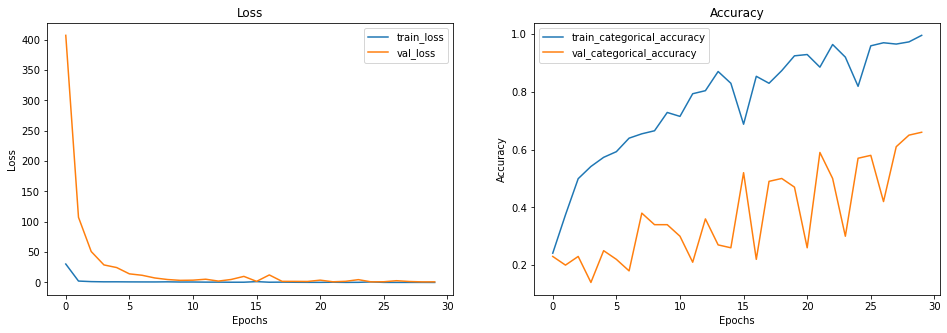

In [44]:
# Model 11 - Conv3D Model with filter size (3,3,3)
frame_height    = 100
frame_width     = 100
num_frames      = 15
size_batch      = 60
num_epochs      = 30
augment         = False
normalize       = False

model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser = optimizers.SGD()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_5_2_SGD', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

- There is no significant improvement in above model architecture

### Model Architecture 6 - CNN LSTM Model

- Now let us create a LSTM model
- Note that, so far for all the Conv3D models, we have used the Relu as activation function
- But for LSTM models, we will use tanh as the activation function. 
- Given that ReLUs can have quite large outputs, they have traditionally been regarded as inappropriate for use with LSTMs

In [46]:
# CNN LSTM Model
def model_LSTM_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.5))
    
    # model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    # model.add(Activation('relu'))
    # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))    
    # model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
 
    model.add(LSTM(units=56, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.25))
   
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [47]:
# Model 12 - CNN LSTM Model

num_frames    = 15
frame_height  = 120
frame_width   = 120
size_batch    = 84
num_epochs    = 100
augment       = False
normalize     = True

model = model_LSTM_1(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 120, 120, 16)  208       
_________________________________________________________________
activation_74 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 60, 60, 32)    2080      
_________________________________________________________________
activation_75 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 32)  

In [48]:
model_history = trainer(model, 'model_LSTM_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Source path =  ./Project_data/train ; batch size = 84
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]
  ...
    to  
  ['...']
Source path =  ./Project_data/val ; batch size = 84
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/100
7/8 [=========================>....] - ETA: 3s - loss: 1.5477 - categorical_accuracy: 0.3265
Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to model_LSTM_1_2021-05-2415_07_23.179269/model-00001-1.52641-0.33333-1.60366-0.18000.h5
8/8 [==============================] - 33s 4s/step - loss: 1.5244 - categorical_accuracy: 0.3333 - val_loss: 1.6037 - val_categorical_accuracy: 0.1800
Epoch 2/100
7/8 [=========================>....] - ETA: 4s - loss: 1.2286 - categorical_accuracy: 0.5357
Epoch 00002: val_categorical_accuracy did not improve from 0.18000
8/8 [==============================] - 40s 5s/step - loss: 1.2267 - categorical

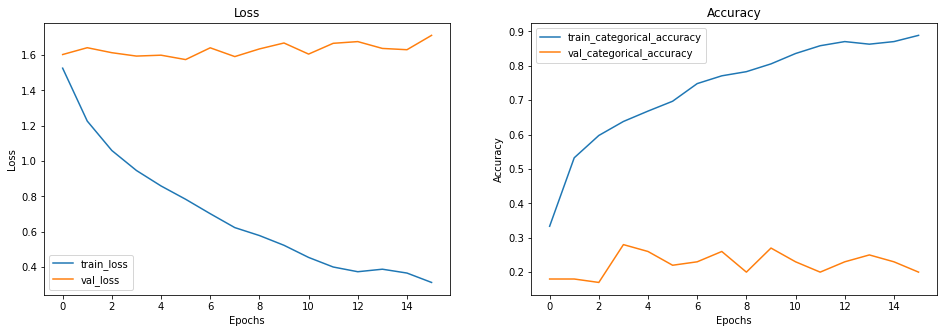

In [49]:
modelplot(model_history)

- The LSTM model performed decently with train accuracy if 92% and validation accuracy of 81%


### Model Architecture 7 - CNN GRU Model

- Let us try GRU instead of LSTM amd see its performace

In [50]:
# CNN GRU Model
def model_GRU_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))    

    # model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    # model.add(Activation('relu'))
    # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))    
    # model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(GRU(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.25))
 
    model.add(GRU(units=50, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [51]:
# Model 13 - CNN GRU Model

num_frames = 16
frame_height = 120
frame_width = 120
size_batch = 64
num_epochs = 100
augment = False
normalize = True

model = model_GRU_1(num_frames, frame_height, frame_width)
optimiser = optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 16, 120, 120, 16)  208       
_________________________________________________________________
activation_79 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 60, 60, 32)    2080      
_________________________________________________________________
activation_80 (Activation)   (None, 16, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 60, 60, 32)  

In [52]:
# Run the model and check accuracy
model_history = trainer(model, 'model_GRU_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Source path =  ./Project_data/train ; batch size = 64
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
  ...
    to  
  ['...']
Source path =  ./Project_data/val ; batch size = 64
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
  ...
    to  
  ['...']
Train for 11 steps, validate for 2 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 3s - loss: 1.6801 - categorical_accuracy: 0.2937
Epoch 00001: val_categorical_accuracy improved from -inf to 0.27000, saving model to model_GRU_1_2021-05-2415_21_10.813099/model-00001-1.67678-0.29110-1.61151-0.27000.h5
11/11 [==============================] - 38s 3s/step - loss: 1.6718 - categorical_accuracy: 0.2911 - val_loss: 1.6115 - val_categorical_accuracy: 0.2700
Epoch 2/100
10/11 [==========================>...] - ETA: 3s - loss: 1.3847 - categorical_accuracy: 0.3969
Epoch 00002: val_categorical_accuracy did not improve from 0.27000
11/11 [==============================] - 42s 4s/step - loss: 1.3820

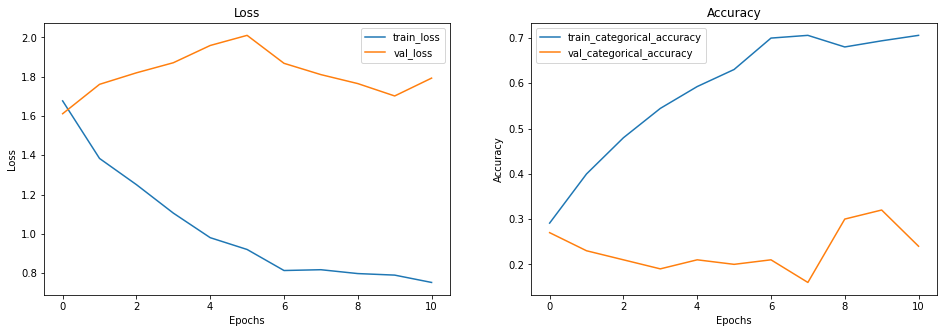

In [53]:
modelplot(model_history)

- Performance of the GRU model above is better than that of the LSTM (Model 12) 
model in terms of higher validation accuracy
- Train accuracy was 98%and validation accuracy is 86%

### Model Architecture 9 - VGG16 LSTM Model

- Now let us try the VGG16 model

In [54]:
# VGG16 LSTM Model
def model_VGG16_TF_1(num_frames, frame_height, frame_width):

    num_class = 5
    
    def create_base():
        conv_base = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(frame_height, frame_width, 3))
        count=0
        for layer in conv_base.layers:
            count = count+1
        print("num of layers in VGG16 " + str(count))
        # training the model after 140 layers
        split_at = 17
        for layer in conv_base.layers[:split_at]: layer.trainable = False
        for layer in conv_base.layers[split_at:]: layer.trainable = True
        x = GlobalAveragePooling2D()(conv_base.output)
        base_model = Model(conv_base.input, x)
        return base_model
    
    conv_base = create_base()
    
    ip = Input(shape=(num_frames, frame_height, frame_width, 3))
    t_conv = TimeDistributed(conv_base)(ip) 
    drop_l = Dropout(0.5)(t_conv)
    t_lstm1 = LSTM(units=128, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(drop_l)
    
    t_lstm2 = LSTM(units=50, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(t_lstm1)

    f_softmax = Dense(num_class, activation='softmax')(t_lstm2)

    model = Model(ip, f_softmax)
    
    return model

In [55]:
# Model 14 - VGG16 transfer Learning Model

num_frames = 15
frame_height = 120
frame_width = 120
size_batch = 50
num_epochs = 100
augment = False
normalize = True

model = model_VGG16_TF_1(num_frames, frame_height, frame_width)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

58892288/58889256 [==============================] - 0s 0us/step
num of layers in VGG16 19
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15, 120, 120, 3)] 0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 512)           14714688  
_________________________________________________________________
dropout_42 (Dropout)         (None, 15, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 128)           328192    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 255       
Total params: 15,078,935
Trainable

In [56]:
# Run the model and check accuracy
model_history = trainer(model, 'model_VGG16_TF_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Source path =  ./Project_data/train ; batch size = 50
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]
  ...
    to  
  ['...']
Source path =  ./Project_data/val ; batch size = 50
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]
  ...
    to  
  ['...']
Train for 14 steps, validate for 2 steps
Epoch 1/100
13/14 [==========================>...] - ETA: 2s - loss: 1.6382 - categorical_accuracy: 0.2323
Epoch 00001: val_categorical_accuracy improved from -inf to 0.25000, saving model to model_VGG16_TF_1_2021-05-2415_32_42.128250/model-00001-1.63981-0.23077-1.60547-0.25000.h5
14/14 [==============================] - 39s 3s/step - loss: 1.6437 - categorical_accuracy: 0.2308 - val_loss: 1.6055 - val_categorical_accuracy: 0.2500
Epoch 2/100
13/14 [==========================>...] - ETA: 2s - loss: 1.6277 - categorical_accuracy: 0.2000
Epoch 00002: val_categorical_accuracy improved from 0.25000 to 0.39000, saving model to model_VGG16_TF_1_2021-05-2415_32_42.128250/mode

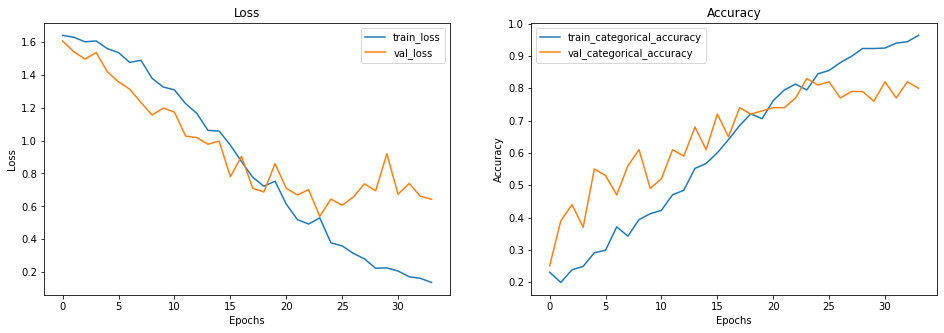

In [58]:
modelplot(model_history)

- Model has performed quite well with 98% train accuracy and 88% validation accuracy

# Load the winner model and Test a sample

- Now that we have chosen the winner, let us load it once and use to predict the class of one random image from the validation set just see if the .h5 file is created correctly and also to see if the model works

In [59]:
# Load the winner model i.e. Model 8 (Conv3D) h5 file
model = load_model('./model_VGG16_TF_1_2021-05-2415_32_42.128250/model-00024-0.52997-0.79487-0.53987-0.83000.h5') 

In [63]:
# Test the model using one random image from the validation data set

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 2, num_frames = 15, 
                    frame_height = 120, frame_width = 120, augment = False, normalize=False)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])

Source path =  ./Project_data/val ; batch size = 2
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]
Actual Class of the Image:     1
Predicted Class of the Image:  1


- The model has correctly predicted the class of the random image chosen

- We end the experimentation now